In [2]:
ownerpath = f'/Users/mia/Desktop/AST443 Observational Techniques in Astronomy'

In [167]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib.dates as mdates

In [107]:
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [108]:
master_dark_data = np.median(dark_frame, axis=0)

In [109]:
dark_frame_3 = []
for i in range(5):
    filename = f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Picture of Object/Andromena/Dark/Andromeda_Visible_Dark_3s_.0000000{i}.DARK.FIT'
    dark_f3 = fits.getdata(filename)
    dark_frame_3.append(dark_f3)

In [110]:
master_dark_data3 = np.median(dark_frame_3, axis=0)

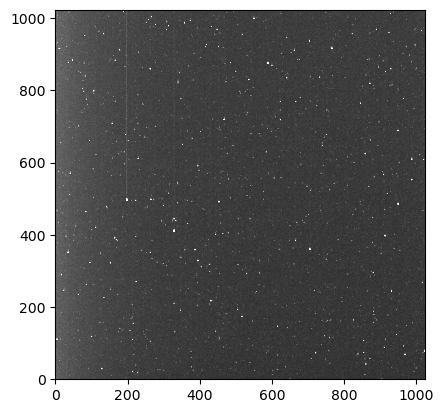

In [111]:
plt.imshow(master_dark_data3, cmap='gray', vmax=np.mean(master_dark_data3)+(np.std(master_dark_data3)), origin='lower')

In [112]:
file_num=[1,2,3,4,5,6,7,8,9]
flat_fields_data=[]

for i in range(len(file_num)):
    field_file=f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.0000000{i}.FLAT.FIT'
    field_file_data=fits.open(field_file)
    flat_fields_data.append(field_file_data[0].data)

# Compute the median flat field
median_flat_field = np.median(flat_fields_data, axis=0)

In [113]:
# Normalizing the flat field
master_flat_field=(median_flat_field-master_dark_data3)/np.max(median_flat_field)


In [114]:
master_flat = fits.getdata(f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/Normalized_Master_Flat-Field.FIT')

#master_flat_n = (master_flat - master_dark_data)
#master_flat_normalized = master_flat_n / np.median(master_flat_n)

In [115]:
science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

In [116]:
calibrated_science_withflat = []
for i in range(194):
    science_corrected = (science_files[i] - master_dark_data)/master_flat_field
    calibrated_science_withflat.append(science_corrected)

    output_file_with = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(science_corrected)
    hdu.writeto(output_file_with, overwrite=True)

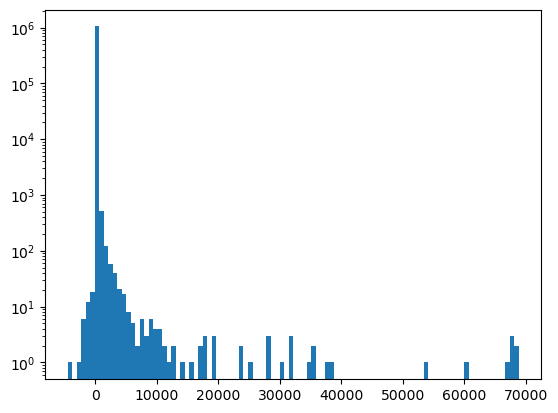

In [117]:

flatten_cal_science=calibrated_science_withflat[0].flatten()
plt.hist(flatten_cal_science, bins=100)
plt.yscale('log')

In [118]:
# calibrated_science_withflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_with =  science_corrected / master_flat
#     calibrated_science_withflat.append(calibrated_data_with)

#     output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_with)
#     hdu.writeto(output_file_with, overwrite=True)

In [ ]:
# calibrated_science_withoutflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_without =  science_corrected / np.mean(science_corrected)
#     calibrated_science_withoutflat.append(calibrated_science_withoutflat)

#     output_file_without = f'{ownerpath}/Lab 2/Subtracted Transient(withoutflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_without)
#     hdu.writeto(output_file_without, overwrite=True)

In [ ]:
# data = fits.getdata(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits')   
# mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
# print(np.array((mean, median, std)))  

In [15]:
# mean, median, std = sigma_clipped_stats(calibrated_science_withflat[0], sigma=3.0)  
# print(np.array((mean, median, std))) 

In [16]:
# daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)  
# sources = daofind(calibrated_science_withflat[0] - median)  
# for col in sources.colnames:  
#     if col not in ('id', 'npix'):
#         sources[col].info.format = '%.2f'  
# sources.pprint(max_width=76)  
# sources.write(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii', overwrite=True)

In [17]:
# dir(DAOStarFinder)

In [119]:
def show_image(data, cmap='gray'):
    """
    Displays an image using the mean and standard deviation for contrast scaling.

    Parameters:
    - data: 2D numpy array, the image data to be displayed.
    - cmap: str, the colormap to be used for displaying the image (default is 'gray').

    Returns:
    - None
    """
    # Calculate the min and max values for display scaling
    mi = np.mean(data) - np.std(data)
    ma = np.mean(data) + 2*np.std(data)
    
    # Display the image with the specified scaling
    plt.imshow(data, cmap=cmap, origin='lower', vmin=mi, vmax=ma)
    plt.colorbar()
    plt.show()

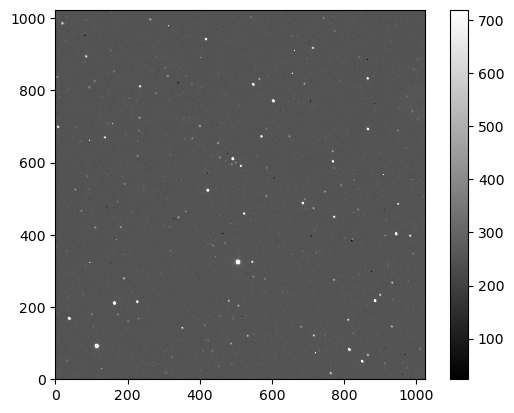

255.47273504528386


In [120]:
# norm = simple_norm(calibrated_science_withflat[0], 'sqrt')

# positions = np.transpose((426.9475, 798.2625))
# apertures = CircularAperture(positions, r=5.0)
#apertures.plot(color='blue', lw=1.5, alpha=0.5)

show_image(calibrated_science_withflat[0])
print(np.mean(calibrated_science_withflat[0]))

In [121]:
good_frames=[]
for i in range(len(calibrated_science_withflat)):
    if np.mean(calibrated_science_withflat[i])<300:
        good_frames.append([calibrated_science_withflat[i]])
        print(np.mean(calibrated_science_withflat[i]))

255.47273504528386
255.03353455068535
254.91020309521517
252.89504597569675
251.0264978062323
251.6801497570081
252.11492689318536
254.58856478651416
253.44232093132393
252.80492076508165
252.24639054919706
253.0719565519303
253.7047340400001
252.00116785778303
252.9276972794943
255.460363056205
254.35443605145255
256.91702849175215
254.89484053327894
254.62686875913215
253.68933577339953
256.0538118578841
256.7182981860944
258.2279917388413
260.8410919602533
261.9061116678273
251.2313992052915
252.89615452630667
250.28473498662086
265.4310982279157
277.51173310759737
259.9950943186133
256.788732914139
263.58929586138674
265.57181671475695
262.6742892895711
272.3286446958635
282.7532028322931
277.21967000251334
262.8490318826862
268.49226164495076
263.0911694678194
255.60746814000356
252.88733814498676
267.9383047946953
265.83346398828394
268.94145909288403
262.52830714642266
274.13678938888415
275.2035266030622
259.87667069628066
255.82209826945595
252.22003989890396
279.7293448994678

In [21]:
#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
#apertures = CircularAperture(positions, r=5.0)
#norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(calibrated_science_withflat[0], cmap='Greys', origin='lower', norm=norm,
#           interpolation='nearest')
#apertures.plot(color='blue', lw=1.5, alpha=0.5)
#plt.show()

In [22]:
# ast = AstrometryNet()
# ast.api_key = 'zxdmyndauvanohii'

# sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [23]:
# ast = AstrometryNet()
# ast.api_key = 'kwbavttkhitkoaeo'

# sources = Table.read(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [24]:
# wcs_header

In [235]:
aligned_images = []
aligned_number = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33,
    36, 37, 38, 39, 40, 42, 43, 59, 63, 70, 71, 72, 74, 75,
    76, 82, 83, 84, 85, 86, 88, 89, 91, 92, 93, 94, 95, 96,
    97, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112,
    114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
    125, 126, 127]

for i in range(len(aligned_number)):
    aligned_file=f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{aligned_number[i]}.fits'
    aligned_file_data=fits.getdata(aligned_file)
    aligned_file_data = aligned_file_data.byteswap(inplace=True).newbyteorder()
    aligned_images.append(aligned_file_data)

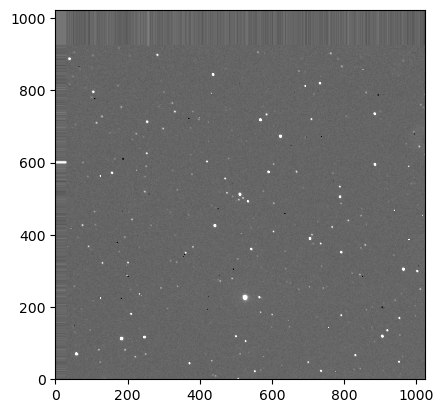

In [236]:
plt.imshow(aligned_images[25], cmap='gray', origin='lower', vmin=100, vmax=500)

In [237]:
(aligned_images[0]).shape

(1024, 1024)

In [238]:
# Define the cropping coordinates
x_min, x_max = 200, 800
y_min, y_max = 200, 800

#fig = plt.figure(figsize=(18, 3))  # width, height in inches
cropped_aligned_frames=[]

#Plot each flat frame
for i in range(len(aligned_images)):
        # Crop the image
    cropped_aligned_frames.append(aligned_images[i][y_min:y_max, x_min:x_max])

In [239]:
len(aligned_number)

84

In [240]:
#remove background

cropped_bkgsub=[]
cbkg_rms=[]

for i in range(len(cropped_aligned_frames)):
    bkg = sep.Background(np.ascontiguousarray(cropped_aligned_frames[i]), bw=100, bh=100)
    cbkg_rms.append(bkg.globalrms)
    cropped_bkgsub.append(cropped_aligned_frames[i]-bkg)

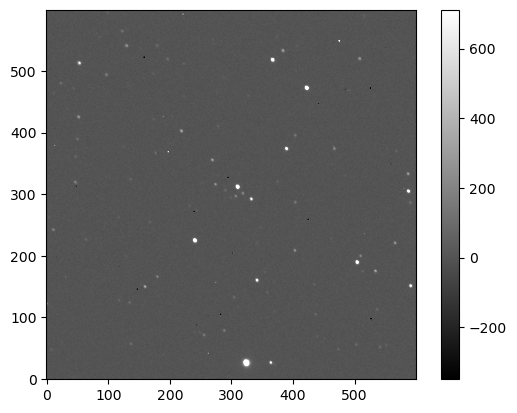

13.252641677856445


In [241]:
show_image(cropped_bkgsub[0])
print(cbkg_rms[55])

In [242]:
#extract objects from frame

frame_objects=[]
for i in range(len(cropped_bkgsub)):
    objects = sep.extract(cropped_bkgsub[i], 12, err=cbkg_rms[i])
    frame_objects.append(objects)

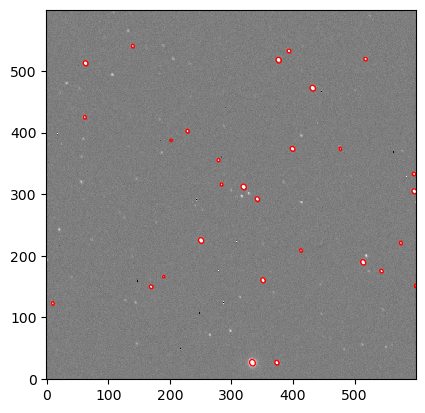

In [243]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(cropped_bkgsub[20]), np.std(cropped_bkgsub[20])
im = ax.imshow(cropped_bkgsub[20], interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(frame_objects[20])):
    e = Ellipse(xy=(frame_objects[20]['x'][i], frame_objects[20]['y'][i]),
                width=6*frame_objects[20]['a'][i],
                height=6*frame_objects[20]['b'][i],
                angle=frame_objects[20]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [244]:
#Extract flux and flux error

fluxes=[]
flux_err=[]
flags=[]

for i in range(len(cropped_bkgsub)):
    flux, fluxerr, flag = sep.sum_circle(cropped_bkgsub[i], frame_objects[i]['x'], frame_objects[i]['y'],
                                     6.6, err=cbkg_rms[i], gain=2.0)
    fluxes.append(flux)
    flux_err.append(fluxerr)
    flags.append(flag)

In [245]:
for i in range(len(frame_objects[0]['x'])):
    print(i,"object {:.3f} {:.3f}: flux = {:f} +/- {:f}".format(frame_objects[0]['x'][i],frame_objects[0]['y'][i], fluxes[0][i], flux_err[0][i]))

0 object 364.063 26.244: flux = 13030.312136 +/- 164.741434
1 object 324.430 26.162: flux = 1045695.194950 +/- 737.185224
2 object 0.927 122.044: flux = 3806.720959 +/- 122.607006
3 object 160.307 149.421: flux = 5848.263980 +/- 153.475540
4 object 590.887 150.749: flux = 15876.213911 +/- 168.987176
5 object 341.733 159.822: flux = 18408.259942 +/- 172.709913
6 object 180.191 165.805: flux = 2984.720738 +/- 148.474378
7 object 533.920 174.755: flux = 5581.002210 +/- 153.059256
8 object 504.173 189.083: flux = 39329.920222 +/- 200.722555
9 object 403.143 208.293: flux = 4384.638353 +/- 151.012757
10 object 565.645 220.376: flux = 4806.355784 +/- 151.709299
11 object 241.096 224.459: flux = 68979.562299 +/- 234.713153
12 object 11.428 241.803: flux = 3356.047417 +/- 149.179105
13 object 332.564 291.566: flux = 14073.030333 +/- 166.243791
14 object 318.869 300.889: flux = 3653.212819 +/- 149.857318
15 object 587.425 304.192: flux = 22345.105020 +/- 178.182306
16 object 310.363 311.430: fl

In [246]:
len(frame_objects)

84

In [247]:
for i in range(len(fluxes)):
    for j in range(len(fluxes[i])):
        if frame_objects[i]['x'][j] > 309 and frame_objects[i]['x'][j] <320:
            if frame_objects[i]['y'][j] > 309 and frame_objects[i]['y'][j] <315:
                print(i, frame_objects[i]['x'][j], frame_objects[i]['y'][j], fluxes[i][j], flux_err[i][j])

0 310.3625818939194 311.4302918320696 71522.1583461022 237.38052048132283
1 310.70663620610605 311.34579549489445 71705.40236150977 248.55525662401055
2 311.1787695274616 312.46338482214026 70784.51405983687 246.68014354522668
3 310.72051862147305 311.3578327778199 71871.16669116853 234.1372377059438
4 310.20718146096607 311.72131507257296 71655.65596118216 248.3566210961766
5 310.73006097388736 312.087410418577 71420.42833562793 246.5064063580856
6 311.10899690460644 311.6355337267004 71419.06002938628 246.79323284457524
7 310.8559020324603 311.5227588768919 71443.6744565475 242.97496035924058
8 311.63644220422987 312.0146678710025 71275.67148474931 237.1733565862867
9 311.19875064178785 311.4930755032559 71788.33847654372 234.11837133566775
10 310.71901291969857 311.8210236746023 71001.83085258004 252.93861402495318
11 311.0828296124297 311.70212523219953 71492.92033403635 238.53099617503895
12 310.65194500370626 311.5221094704086 70383.20355203388 238.22480582732388
13 311.654491966

In [248]:


def extract_flux_table(frame_objects, fluxes, flux_err, x_min, x_max, y_min, y_max):
    """
    Extracts the flux and flux error of objects within a specified pixel range and stores them in a table.

    Parameters:
    - frame_objects: list of dictionaries, where each dictionary contains 'x' and 'y' coordinates of objects in a frame.
    - fluxes: list of lists, where each sublist contains flux values for objects in a frame.
    - flux_err: list of lists, where each sublist contains flux error values for objects in a frame.
    - x_min: int, the minimum x-coordinate range.
    - x_max: int, the maximum x-coordinate range.
    - y_min: int, the minimum y-coordinate range.
    - y_max: int, the maximum y-coordinate range.

    Returns:
    - table: Astropy Table containing columns 'frame', 'x', 'y', 'flux', and 'flux_err'.
    """
    # Define lists to store the data
    frame_list = []
    x_list = []
    y_list = []
    flux_list = []
    flux_err_list = []

    # Iterate through each frame and each object's coordinates
    for i in range(len(fluxes)):
        for j in range(len(fluxes[i])):
            # Check if the object's coordinates are within the specified range
            x = frame_objects[i]['x'][j]
            y = frame_objects[i]['y'][j]
            if x_min < x < x_max and y_min < y < y_max:
                # Append the data to respective lists
                frame_list.append(i)
                x_list.append(x)
                y_list.append(y)
                flux_list.append(fluxes[i][j])
                flux_err_list.append(flux_err[i][j])

    # Create a table with the gathered data
    table = Table([frame_list, x_list, y_list, flux_list, flux_err_list], 
                  names=('frame', 'x', 'y', 'flux', 'flux_err'))

    return table

In [249]:
host_planet= extract_flux_table(frame_objects, fluxes, flux_err, 309, 320, 309, 315)

In [250]:
for i in range(len(fluxes)):
    for j in range(len(fluxes[i])):
        if fluxes[i][j] > 9500 and fluxes[i][j] <100000:
            if not host_planet['flux'][i]==fluxes[i][j]:
                 print(i, frame_objects[i]['x'][j], frame_objects[i]['y'][j], fluxes[i][j], flux_err[i][j])

0 364.06347997363156 26.243966711118997 13030.312135636063 164.7414342767158
0 590.8872872268527 150.74936762782488 15876.213910576704 168.98717631885563
0 341.7325808813374 159.82151154497322 18408.25994193386 172.70991306435883
0 504.1726008769214 189.08262891734486 39329.920221588 200.72255531087046
0 241.09643771893838 224.45868737396364 68979.56229905965 234.7131527419417
0 332.5636702622462 291.56572224034585 14073.030333178041 166.24379112352213
0 587.4250665933607 304.19195894371677 22345.105020368097 178.1823062245998
0 389.62967063541777 373.2188122995243 22088.8857779783 177.8563330891587
0 422.4193433858576 471.796634013125 63673.89619215609 228.91325703814414
0 53.639657656508625 511.96089557718545 14531.218054897785 166.9674894630111
0 367.1412759484396 517.310971360903 35639.40862579225 196.0414186416431
1 364.4383261822302 26.183354688819914 13142.101198098393 180.23015133163705
1 591.2170609231102 150.74953415680903 16105.101288824551 184.29435014234122
1 342.073886843

In [251]:
# reference_star_1= extract_flux_table(frame_objects, fluxes, flux_err, 363.9476029334338, 365.9262928489079, 25.760355507546407, 27.383059608692506)
# reference_star_2= extract_flux_table(frame_objects, fluxes, flux_err, 590.8054497427934, 592.5538406432704, 150.3888335234611, 151.8142464596994)
# reference_star_3= extract_flux_table(frame_objects, fluxes, flux_err, 341.61174624439514, 343.3596409018714, 159.44951879026888, 160.94036875683386)
# reference_star_4= extract_flux_table(frame_objects, fluxes, flux_err, 504.0440846374132, 505.8041438890214, 188.6671699108461, 190.14533884923551)
# reference_star_5= extract_flux_table(frame_objects, fluxes, flux_err, 240.9930939608208, 242.6546714476923, 223.86177971469291, 225.5662476380141)
# reference_star_6= extract_flux_table(frame_objects, fluxes, flux_err, 332.4245130656536, 334.1069052554858, 291.0287922845138, 292.615029265007)
# reference_star_7= extract_flux_table(frame_objects, fluxes, flux_err, 587.2689095398096, 588.8302155153921, 303.85929677051473, 305.32253085354364)
# reference_star_8= extract_flux_table(frame_objects, fluxes, flux_err, 389.4510972644726, 391.0421558820256, 372.84644135255337, 374.3059639602824)
# reference_star_9= extract_flux_table(frame_objects, fluxes, flux_err, 422.2612691909836, 423.7883211860701, 471.44374866072366, 472.97426922408266)
# reference_star_10= extract_flux_table(frame_objects, fluxes, flux_err, 53.54883706315202, 55.13588108155239, 511.259072945376, 513.2838655701547)
# reference_star_11= extract_flux_table(frame_objects, fluxes, flux_err, 366.9755960466421, 368.5111767531758, 516.9240447317924, 518.5150819373945)
# nofr = 11

In [252]:
reference_star_1= extract_flux_table(frame_objects, fluxes, flux_err, 362, 374, 24, 28)
reference_star_2= extract_flux_table(frame_objects, fluxes, flux_err, 589, 599, 150, 154)
reference_star_3= extract_flux_table(frame_objects, fluxes, flux_err, 340, 352, 158, 162)
reference_star_4= extract_flux_table(frame_objects, fluxes, flux_err, 503, 514, 187, 191)
reference_star_5= extract_flux_table(frame_objects, fluxes, flux_err, 240, 251, 222, 226)
reference_star_6= extract_flux_table(frame_objects, fluxes, flux_err, 332, 344, 289, 293)
reference_star_7= extract_flux_table(frame_objects, fluxes, flux_err, 586, 598, 302, 306)
reference_star_8= extract_flux_table(frame_objects, fluxes, flux_err, 388, 400, 371, 375)
reference_star_9= extract_flux_table(frame_objects, fluxes, flux_err, 420, 432, 470, 474)
reference_star_10= extract_flux_table(frame_objects, fluxes, flux_err, 53, 64, 510, 514)
reference_star_11= extract_flux_table(frame_objects, fluxes, flux_err, 366, 378, 515, 519)
nofr = 11

In [253]:
length = []

length.append(len(reference_star_1))
length.append(len(reference_star_2))
length.append(len(reference_star_3))
length.append(len(reference_star_4))
length.append(len(reference_star_5))
length.append(len(reference_star_6))
length.append(len(reference_star_7))
length.append(len(reference_star_8))
length.append(len(reference_star_9))
length.append(len(reference_star_10))
length.append(len(reference_star_11))
print(length)
range_len = max(length)
print(range_len)

[84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]
84


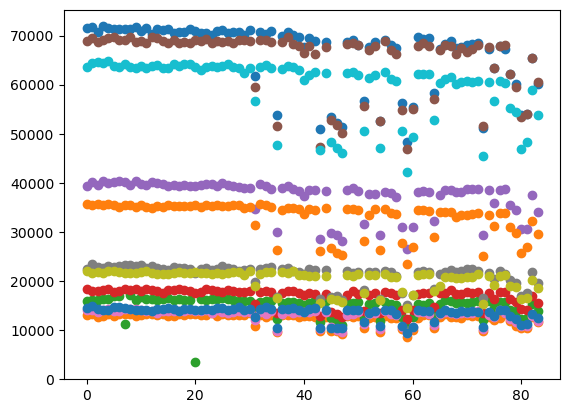

In [254]:
# Get the minimum length among all the data
min_len = min(len(host_planet), len(reference_star_1), len(reference_star_2),
              len(reference_star_3), len(reference_star_4), len(reference_star_5),
              len(reference_star_6), len(reference_star_7), len(reference_star_8),
              len(reference_star_9), len(reference_star_10), len(reference_star_11))
# Use the minimum length for the x-axis
x_axis = np.arange(min_len)
# Plot the data, truncating to the minimum length
plt.scatter(x_axis, host_planet['flux'][:min_len], label='host_planet')
plt.scatter(x_axis, reference_star_1['flux'][:min_len], label='reference_star_1')
plt.scatter(x_axis, reference_star_2['flux'][:min_len], label='reference_star_2')
plt.scatter(x_axis, reference_star_3['flux'][:min_len], label='reference_star_3')
plt.scatter(x_axis, reference_star_4['flux'][:min_len], label='reference_star_4')
plt.scatter(x_axis, reference_star_5['flux'][:min_len], label='reference_star_5')
plt.scatter(x_axis, reference_star_6['flux'][:min_len], label='reference_star_6')
plt.scatter(x_axis, reference_star_7['flux'][:min_len], label='reference_star_7')
plt.scatter(x_axis, reference_star_8['flux'][:min_len], label='reference_star_8')
plt.scatter(x_axis, reference_star_9['flux'][:min_len], label='reference_star_9')
plt.scatter(x_axis, reference_star_10['flux'][:min_len], label='reference_star_10')
plt.scatter(x_axis, reference_star_11['flux'][:min_len], label='reference_star_11')
#plt.legend()  # Add a legend to distinguish the stars
plt.show()

In [255]:
#plt.scatter(np.arange(len(fluxes)), host_planet['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_1['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_2['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_3['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_4['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_5['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_6['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_7['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_8['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_9['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_10['flux'])
#plt.scatter(np.arange(len(fluxes)), reference_star_11['flux'])

In [256]:
reference_star = []
for i in range(1, nofr+1):  
    reference_star.append(np.array(eval(f'reference_star_{i}')))

In [257]:
reference_star_1

frame,x,y,flux,flux_err
int64,float64,float64,float64,float64
0,364.06347997363156,26.243966711118997,13030.312135636063,164.7414342767158
1,364.4383261822302,26.183354688819914,13142.101198098393,180.23015133163705
2,364.8636297822053,27.383059662377462,12649.3613597995,178.27932260774088
3,364.50247223257776,26.070733417990613,12871.214251942041,159.08878753913856
4,363.9476029291294,26.47073956714097,13281.801733793018,180.2611553513825
5,364.4030666138533,26.910549483216858,12844.124552823303,177.3357771192266
...,...,...,...,...
77,364.99383489392454,26.5131348330836,13209.513741225,175.24966209270042
78,365.04076581691845,26.21659256056858,11764.82776460945,181.81074780170687


# 4.4

In [258]:
ref_flux_ = []

for i in range(nofr):
    ref_flux_.append([])  

In [259]:
ref_flux_err_ = [] 

for i in range(nofr):
    ref_flux_err_.append([]) 

In [261]:
len(reference_star_1)

84

In [262]:
np.mean(reference_star[i]['flux_err'])

205.18060696798753

In [263]:
mean_ref = []
for i in range(nofr):
    ref_flux_[i]=(reference_star[i]['flux'])
    ref_flux_err_[i]=(reference_star[i]['flux_err'])
        
    target_mean = np.mean(reference_star[i]['flux'])
    mean_ref.append(target_mean)

In [264]:
ref_flux_

[array([13030.31213564, 13142.1011981 , 12649.3613598 , 12871.21425194,
        13281.80173379, 12844.12455282, 13241.72445464, 13204.5098259 ,
        13132.79054281, 12747.90982405, 13007.20719135, 13149.49979187,
        13250.59226902, 13111.33525625, 13284.30014417, 12888.97832176,
        12813.03832467, 13131.85850854, 12915.42536759, 13172.96651671,
        13205.59732389, 13065.32305178, 13100.71544773, 13478.54815775,
        12751.82390741, 13152.9389606 , 13000.49162691, 13020.40857772,
        13014.98826548, 13079.42559315, 13455.23051892, 10686.72948936,
        12942.95140812, 12705.55929184, 13026.10242326,  9599.62704343,
        12919.07438001, 12929.48158907, 12931.90326563, 12551.43197056,
        12840.541788  , 12728.28955877, 12706.00994972,  9695.08888649,
        12598.69416624,  9789.5207777 ,  9671.69523647,  9060.74839576,
        12719.61757407, 12677.57833752, 12890.28294794, 10388.32965446,
        12348.72425825, 12688.14777803,  9630.5505173 , 12790.29

In [265]:
final_ref_flux_ = []

for i in range(nofr):
    final_ref_flux_.append([]) 

In [266]:
final_ref_flux_err_ = []

for i in range(nofr):
    final_ref_flux_err_.append([]) 

In [267]:
for i in range(nofr):
    needed_ref_flux = ref_flux_[i]
    needed_ref_flux_err = ref_flux_err_[i]
    for j in range(len(reference_star_1)):
        final_ref_flux = needed_ref_flux[j]/mean_ref[i]
        final_ref_flux_[i].append(final_ref_flux)
        
        final_ref_flux_err = needed_ref_flux_err[j]/mean_ref[i]
        final_ref_flux_err_[i].append(final_ref_flux_err) 

# 4.5

In [362]:
mu_ref_up = []
mu_ref_down = []

for j in range(len(reference_star_1)):
    a = 0
    b = 0
    for i in range(nofr):
        a += float(final_ref_flux_[i][j])/((float(final_ref_flux_err_[i][j]))**2)
        b += 1/((float(final_ref_flux_err_[i][j]))**2)
    
    mu_ref_up.append(a)
    mu_ref_down.append(b)

In [372]:
mu = []
delta_ref = []

for i in range(len(reference_star_1)):
    c = mu_ref_up[i]/mu_ref_down[i]
    d = math.sqrt(1/mu_ref_down[i])
    mu.append(c)
    delta_ref.append(d)

In [373]:
mu

[1.0646638371016912,
 1.0740462724350406,
 1.0668558500160266,
 1.069504715234432,
 1.0741570808073848,
 1.071361007340162,
 1.0683464119542854,
 1.0615756518329846,
 1.070396626391795,
 1.062485892882592,
 1.065968604826207,
 1.0596325677117133,
 1.0677243413197979,
 1.0657329201560255,
 1.060196712185066,
 1.0585457025478788,
 1.064240644547436,
 1.06108315351773,
 1.0632959214698472,
 1.0614920578857505,
 1.012880390612199,
 1.0577130103503132,
 1.0656357658495013,
 1.0607819902629458,
 1.0610594169983372,
 1.062745944604969,
 1.064123410427191,
 1.0600000949983048,
 1.060211563622313,
 1.0502372062957754,
 1.0581565291159916,
 0.9284222049916745,
 1.0622894995642076,
 1.062570657135415,
 1.055683272188095,
 0.7943190832365642,
 1.049754002345204,
 1.063269175569073,
 1.0532846069102484,
 1.0420095090785293,
 1.0176508023110056,
 1.0397113172193149,
 1.035563255713941,
 0.7592382196354989,
 1.0403993929305024,
 0.8052915956697201,
 0.7866046558916833,
 0.7637193875595367,
 1.0418372

In [365]:
host_planet_flux = host_planet['flux']
host_planet_err = host_planet['flux_err']
    
host_mean = np.mean(host_planet_flux)

In [366]:
host = []
host_err = []

for i in range(len(reference_star_1)):
    e = host_planet_flux[i]/host_mean
    host.append(e)
    f = host_planet_err[i]/host_mean
    host_err.append(f)

In [367]:
#host

In [368]:
r = []

for i in range(len(reference_star_1)):
    g = host[i]/mu[i]
    r.append(g)

In [378]:
r

[1.008680884791862,
 1.0024311800376262,
 0.9962267380689708,
 1.0090151172861535,
 1.0016323950391923,
 1.0009497980092963,
 1.0037549869203921,
 1.010505113623311,
 0.9998210305053505,
 1.0145101843420852,
 1.000117013635579,
 1.0130559260099548,
 0.9897729221762371,
 1.0056082046186343,
 1.0071730427807424,
 1.0128208440163156,
 0.9964738991967763,
 1.0000118106204123,
 0.9982934430029631,
 1.0084226853299798,
 1.0509951841939367,
 1.0014874780052838,
 0.993552048522411,
 0.9933157591169828,
 1.0052382201659393,
 1.0045757784997646,
 0.9950035910266923,
 1.0033811176462526,
 1.0030823419533144,
 1.0025233915474596,
 1.0110081704004026,
 0.9996943339815965,
 1.0009352114169734,
 0.9948323803902612,
 1.0081942050876793,
 1.0155504093005936,
 1.0010237300618736,
 1.0002111531579947,
 1.0011015485325279,
 1.0044643423384616,
 0.9977260002334596,
 1.0051301180094863,
 0.9985888536252662,
 1.0072029459669045,
 0.9925766942967418,
 0.9943212536759812,
 0.9957002169101952,
 1.01123656309030

In [370]:
#final_ref_flux_err_[0]

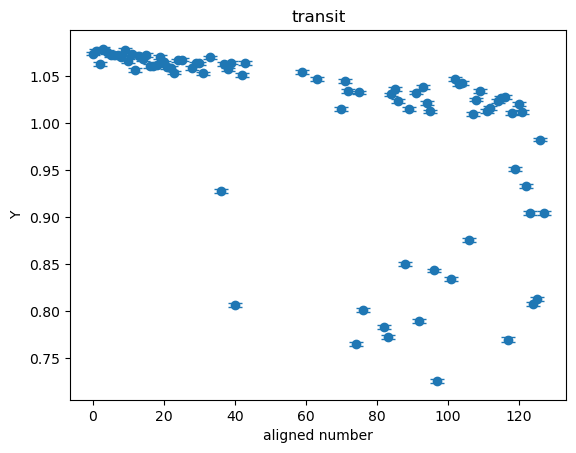

In [374]:
x = aligned_number  
y = host   

#plt.scatter(x, y)  
plt.errorbar(x, y, yerr=delta_ref, fmt='o', capsize=5)
plt.xlabel('aligned number')
plt.ylabel('Y')
plt.title('transit')

plt.show()

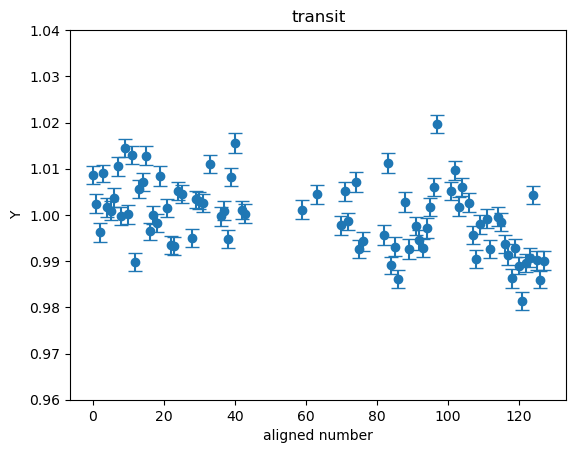

In [375]:
x = aligned_number  
y = r   

#plt.scatter(x, y)  
plt.errorbar(x, y, yerr=delta_ref, fmt='o', capsize=5)
plt.ylim(0.96,1.04)
plt.xlabel('aligned number')
plt.ylabel('Y')
plt.title('transit')

plt.show()

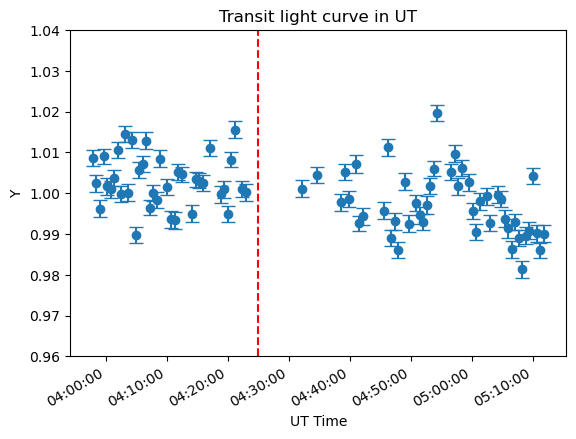

In [376]:
frame_times_ut = [
    "03:57:55", "03:58:30", "03:59:05", "03:59:40", "04:00:15", "04:00:50",
    "04:01:25", "04:01:59", "04:02:35", "04:03:10", "04:03:45", "04:04:20",
    "04:04:55", "04:05:30", "04:06:05", "04:06:40", "04:07:15", "04:07:49",
    "04:08:24", "04:08:59", "04:09:34", "04:10:09", "04:10:44", "04:11:19",
    "04:11:54", "04:12:29", "04:14:13", "04:14:48", "04:15:23", "04:15:58",
    "04:17:08", "04:18:52", "04:19:27", "04:20:02", "04:20:37", "04:21:12",
    "04:22:22", "04:22:57", "04:32:15", "04:34:35", "04:38:39", "04:39:14",
    "04:39:49", "04:40:59", "04:41:33", "04:42:08", "04:45:38", "04:46:13",
    "04:46:48", "04:47:22", "04:47:57", "04:49:07", "04:49:42", "04:50:52",
    "04:51:27", "04:52:01", "04:52:36", "04:53:11", "04:53:46", "04:54:21",
    "04:56:41", "04:57:15", "04:57:50", "04:58:25", "04:59:35", "05:00:10",
    "05:00:45", "05:01:20", "05:02:29", "05:03:04", "05:04:14", "05:04:49",
    "05:05:24", "05:05:59", "05:06:34", "05:07:09", "05:07:43", "05:08:18",
    "05:08:53", "05:09:28", "05:10:03", "05:10:38", "05:11:13", "05:11:48"
]

# Convert times to datetime objects in UT
times_ut = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]

# x-axis will now be the original UT times
x = times_ut
y = r  # Your flux data

# Plot the updated graph
plt.errorbar(x, y, yerr=delta_ref, fmt='o', capsize=5)
plt.ylim(0.96, 1.04)
plt.xlabel('UT Time')
plt.ylabel('Y')
plt.title('Transit light curve in UT')
plt.axvline(datetime.strptime("04:25:00", "%H:%M:%S"), color='r', linestyle='--', label='04:25:00')

# Format the x-axis to display HH:MM:SS in UT
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.show()

In [392]:
fit1 = []
fit2 = []
for i in range(len(reference_star_1)):
    if i <= 37:
        fit1.append(r[i])
    else:
        fit2.append(r[i])
        
mean1 = np.mean(fit1)
mean2 = np.mean(fit2)

In [393]:
mean1

1.0043126769601907

In [394]:
r_nor = []
delta_ref_nor = []

for i in range(len(reference_star_1)):
    r_norm = r[i]/mean1
    delta_nor = delta_ref[i]/mean1
    r_nor.append(r_norm)
    delta_ref_nor.append(delta_nor)

In [395]:
fit1_nor = []
fit2_nor = []
for i in range(len(reference_star_1)):
    if i <= 47:
        fit1_nor.append(r_nor[i])
    else:
        fit2_nor.append(r_nor[i])
        
mean1_nor = np.mean(fit1_nor)
mean2_nor = np.mean(fit2_nor)

In [396]:
mean1_nor

0.99927234163624

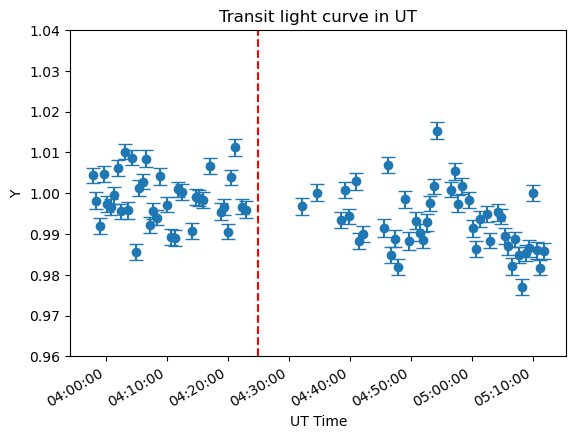

In [397]:
frame_times_ut = [
    "03:57:55", "03:58:30", "03:59:05", "03:59:40", "04:00:15", "04:00:50",
    "04:01:25", "04:01:59", "04:02:35", "04:03:10", "04:03:45", "04:04:20",
    "04:04:55", "04:05:30", "04:06:05", "04:06:40", "04:07:15", "04:07:49",
    "04:08:24", "04:08:59", "04:09:34", "04:10:09", "04:10:44", "04:11:19",
    "04:11:54", "04:12:29", "04:14:13", "04:14:48", "04:15:23", "04:15:58",
    "04:17:08", "04:18:52", "04:19:27", "04:20:02", "04:20:37", "04:21:12",
    "04:22:22", "04:22:57", "04:32:15", "04:34:35", "04:38:39", "04:39:14",
    "04:39:49", "04:40:59", "04:41:33", "04:42:08", "04:45:38", "04:46:13",
    "04:46:48", "04:47:22", "04:47:57", "04:49:07", "04:49:42", "04:50:52",
    "04:51:27", "04:52:01", "04:52:36", "04:53:11", "04:53:46", "04:54:21",
    "04:56:41", "04:57:15", "04:57:50", "04:58:25", "04:59:35", "05:00:10",
    "05:00:45", "05:01:20", "05:02:29", "05:03:04", "05:04:14", "05:04:49",
    "05:05:24", "05:05:59", "05:06:34", "05:07:09", "05:07:43", "05:08:18",
    "05:08:53", "05:09:28", "05:10:03", "05:10:38", "05:11:13", "05:11:48"
]

# Convert times to datetime objects in UT
times_ut = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]

# x-axis will now be the original UT times
x = times_ut
y = r_nor  # Your flux data

# Plot the updated graph
plt.errorbar(x, y, yerr=delta_ref_nor, fmt='o', capsize=5)
plt.ylim(0.96, 1.04)
plt.xlabel('UT Time')
plt.ylabel('Y')
plt.title('Transit light curve in UT')
plt.axvline(datetime.strptime("04:25:00", "%H:%M:%S"), color='r', linestyle='--', label='04:25:00')

# Format the x-axis to display HH:MM:SS in UT
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.show()

the mean value before the transit is 0.999272
the mean value during the transit is 0.991784
the difference ε is 0.007489


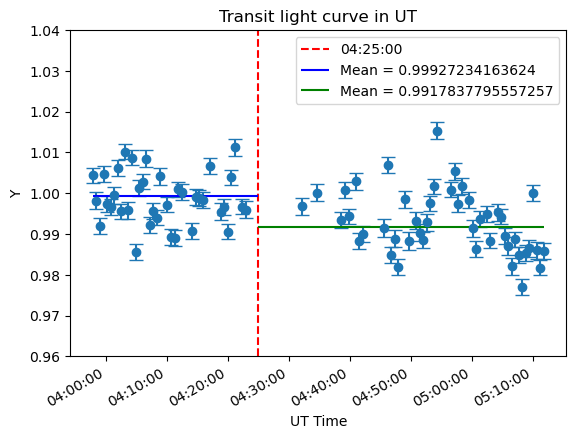

In [401]:
times_ut = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]

#set the target time as "04:25:00"
target_time = datetime.strptime("04:25:00", "%H:%M:%S") 

print(f'the mean value before the transit is {mean1_nor:.6f}')
print(f'the mean value during the transit is {mean2_nor:.6f}')
print(f'the difference \u03B5 is {mean1_nor-mean2_nor:.6f}')

plt.errorbar(times_ut, r_nor, yerr=delta_ref_nor, fmt='o', capsize=5)
plt.ylim(0.96, 1.04)
plt.xlabel('UT Time')
plt.ylabel('Y')
plt.title('Transit light curve in UT')


plt.axvline(target_time, color='r', linestyle='--', label='04:25:00')
#line of mean value before the transit
plt.hlines(mean1_nor, xmin=times_ut[0], xmax=target_time, color='blue', linestyle='-', label=f'Mean = {mean1_nor}')
#line of mean value during the transit
plt.hlines(mean2_nor, xmin=target_time, xmax=times_ut[-1], color='green', linestyle='-', label=f'Mean = {mean2_nor}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

In [264]:
def align_images(images, star_coords, center_coords):
    aligned_images = []

    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)

    return aligned_images

In [273]:
def save_aligned_images(aligned_images, ownerpath):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits', overwrite=True)

In [274]:
# Define paths
input_directory = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/'
output_directory = f'{ownerpath}/Lab 2/Aligned Images/'

# List of your FITS files with full paths
filenames = [f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits' for i in [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31,
    33, 37, 38, 39, 42, 43, 59, 63, 70, 71, 72, 75, 84, 85,
    86, 89, 91, 93, 94, 95, 102, 103, 104, 107, 108, 109,
    111, 112, 114, 115, 116, 118, 120, 121, 122, 126
]]


# Star coordinates in each image
star_coords = [
    (493.338, 609.667), (490.2, 613.8), (501, 595.338), (498.6, 600.6),
    (496.2, 604.2), (513, 577.338), (540, 535.338), (537.2, 539.667),
    (533.338, 543.338), (530.5, 548.338), (528, 552.2), (524.667, 556.3),
    (522.2, 560.5), (518.338, 564.667), (516.3, 568.338), (513, 572.2),
    (510.5, 575.5), (507.2, 579.667), (503.338, 583.5), (501, 587.2),
    (489, 590.5), (494.667, 594.667), (492.2, 598.338), (488.338, 602.2),
    (485.5, 606.3), (482.2, 610.5), (473, 621.3), (470.5, 624.667),
    (466.338, 628.5), (463.338, 632.2), (457.2, 639.667), (445, 653.338),
    (441.667, 657.338), (438.667, 660.5), (429.667, 670.667), (426, 674.338),
    (410, 671.667), (396.833, 683.5), (438, 605.5), (434.667, 608),
    (431.3, 610.5), (419.667, 619.667), (386.3, 644.667), (382.167, 647.2),
    (378.833, 650.5), (368, 658), (359.667, 663.883), (352.2, 669.667),
    (348.833, 673), (344.667, 675.5), (316, 696.3), (312.2, 698.833),
    (308.5, 701.883), (394.3, 561.833), (443.833, 485.5), (492.2, 408.833),
    (484.667, 413), (481.3, 414.667), (473, 418.833), (469.667, 421.3),
    (466.3, 423), (458, 427.2), (450.5, 432.2), (446.3, 433.833),
    (442.2, 436.3), (425.5, 44.667)]

In [275]:
# Center of the image
center_coords = (512, 512)  # For a 1024x1024 image

# Function to load images
def load_fits_images(filepaths):
    return [fits.getdata(fp) for fp in filepaths]

# Function to align images
def align_images(images, star_coords, center_coords):
    aligned_images = []
    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)
    return aligned_images

# Function to save aligned images
def save_aligned_images(aligned_images, output_directory, base_name):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(os.path.join(output_directory, f"{base_name}.{i}.fits"), overwrite=True)

# Load images
filepaths = [os.path.join(input_directory, fname) for fname in filenames]
images = load_fits_images(filepaths)

# Align images
aligned_images = align_images(images, star_coords, center_coords)

# Save aligned images
#save_aligned_images(aligned_images, output_directory, "aligned_HAT_P_16_VISIBLE_LIGHT_20S_")

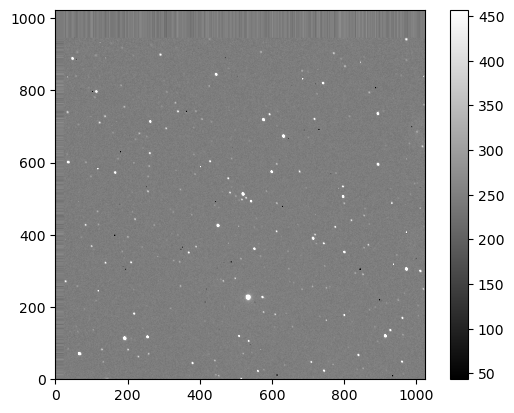

In [283]:
plt.imshow(aligned_images[20], cmap='gray', origin='lower', vmin=np.mean(aligned_images[0])-np.std(aligned_images[0]), vmax=np.mean(aligned_images[0])+np.std(aligned_images[0]))
plt.colorbar()
plt.show()